Structure of this exercise:
- Introduction to Vesder case from news clips.
- Load in the 'ensemble'. Explain that it is not a real ensemble, as in operational weather forecasting.
- 

# Import packages

First, we import the necessary packages for exploring the data.

In [15]:
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import numpy as np
import cartopy.feature as cfeature

# Load in the dataset(s)

In [16]:
def preprocess_dataset(ds, tstart, tstop):
    ds = ds.sel(time=slice(tstart, tstop))
    tas_vars = ["tas", "tasmax", "tasmin"]
    for tas_var in tas_vars:
        if tas_var in ds:
            ds[tas_var].values = ds[tas_var].values - 273.15
            ds[tas_var].attrs["units"] = "°C"
    if "pr" in ds:
        ds.pr.values = ds.pr.values * 3600
        ds.pr.attrs["units"] = "mm/h"
    
    return ds

In [17]:
run_name = "baseline"
run_info_list = [("2021070100", 384), 
                 ("2021071000", 168), 
                 ("2021071012", 156),
                 ("2021071100", 144),
                 ("2021071112", 144), 
                 ("2021071200", 144), 
                 ("2021071212", 144)]
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"

In [18]:
ds_list = list()

for run_info in run_info_list:
    rstart, nhours = run_info
    filepath = f"../data/{run_name}_{rstart}_{nhours}*.nc"
    ds = xr.open_mfdataset(filepath, engine="netcdf4", chunks="auto").assign_coords(rstart=rstart)
    ds = preprocess_dataset(ds, tstart, tstop)
    ds_list.append(ds)

ds = xr.concat(ds_list, dim="rstart")
ds.load()

<xarray.Dataset>
Dimensions:    (time: 48, lon: 75, lat: 70, bnds: 2, rstart: 7)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-13T09:00:00 ... 2021-07-15T08:00:00
  * lon        (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat        (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds  (time, bnds) datetime64[ns] 2021-07-13T09:00:00 ... 2021-07-15...
  * rstart     (rstart) <U10 '2021070100' '2021071000' ... '2021071212'
Dimensions without coordinates: bnds
Data variables:
    pr         (rstart, time, lat, lon) float32 0.8933 0.7801 ... 0.02923 0.0219
    tas        (rstart, time, lat, lon) float32 16.52 16.74 ... 19.37 19.28
    tasmax     (rstart, time, lat, lon) float32 nan nan nan nan ... nan nan nan
    tasmin     (rstart, time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-10-25T11:53:17Z
    frequency:                 1hr
    StartTime:                 2021-07-01T00:00
    EndTime:                   2021-07-17T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

# Plot the 48-hour accumulated precipitation

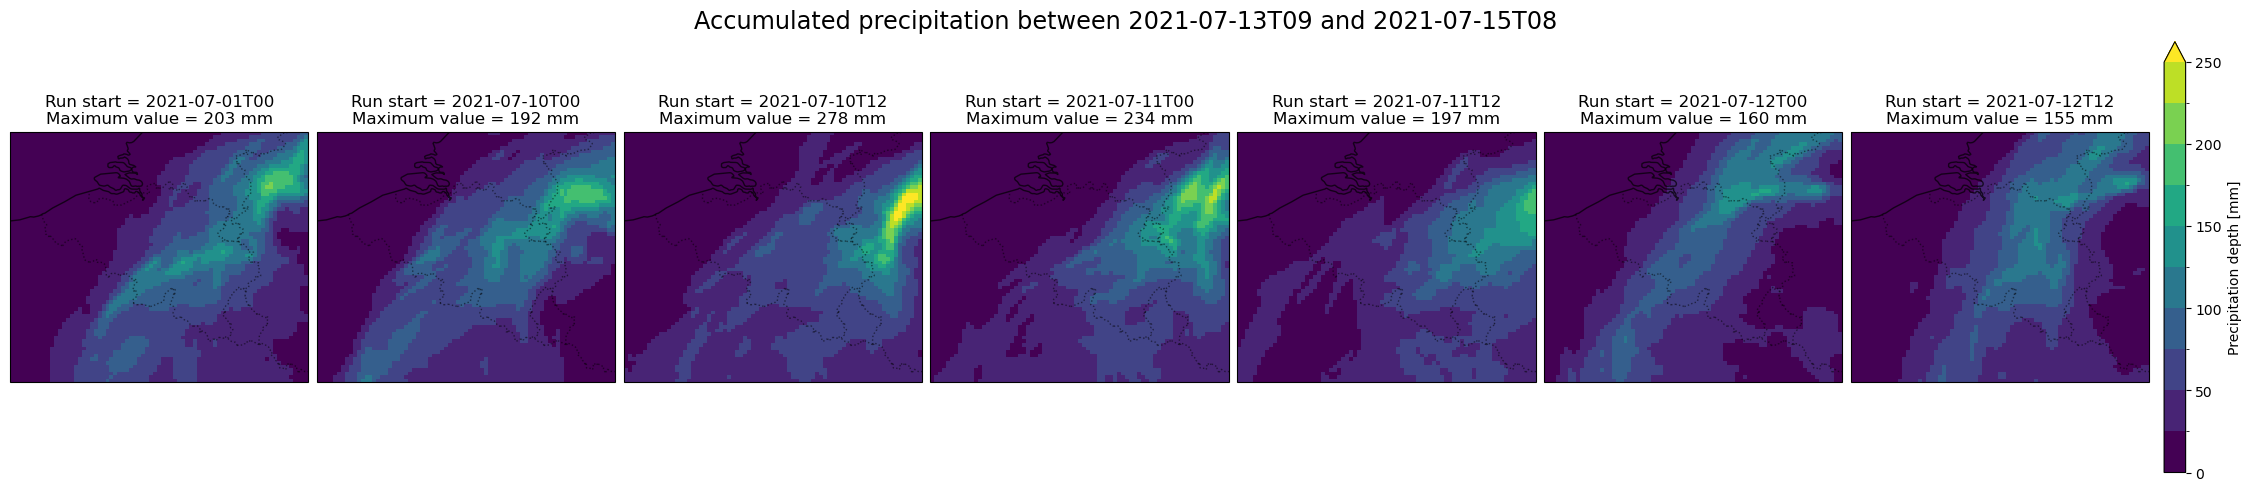

In [5]:
pr = ds.pr
pr_sum = pr.sum("time", skipna=False)

ncols = len(run_info_list)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols * 3.2, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

for idx in range(len(run_info_list)):
    rstart, _ = run_info_list[idx]
    ax = axs[idx]
    p = pr_sum.sel(rstart=rstart).plot(ax=ax, x="lon", y="lat", levels=np.arange(0, 251, 25), add_colorbar=False, extend="max")
    ax.set_title(f"Run start = {rstart[:4]}-{rstart[4:6]}-{rstart[6:8]}T{rstart[8:]}\nMaximum value = {pr_sum.sel(rstart=rstart).max().values:.0f} mm")
    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
    ax.set_aspect(1.4)

fig.colorbar(p, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="xx-large")
plt.show()

# Mask with RMI warning levels

In [6]:
def mask_pr(pr, thresholds_list):

    mask_list = list()

    for idx in range(len(thresholds_list)):
        hours, thresh = thresholds_list[idx]

        pr_rolling_sum = pr.rolling(time=hours).sum()
        mask = (pr_rolling_sum > thresh).any("time")

        mask_list.append(mask.assign_coords(idx=idx))

    mask = xr.concat(mask_list, dim="idx").any("idx")
    return pr.where(mask)

In [22]:
yellow_thresholds_list = [(1, 20), (6, 20), (24, 25)]
orange_thresholds_list = [(1, 30), (6, 40), (24, 50)]
red_thresholds_list    = [(1, 50), (6, 60), (24, 100)]

pr = ds.pr
pr_masked = mask_pr(pr, red_thresholds_list)

Text(0.5, 0.98, 'Accumulated precipitation between 2021-07-13T09 and 2021-07-15T08 (red warning)')

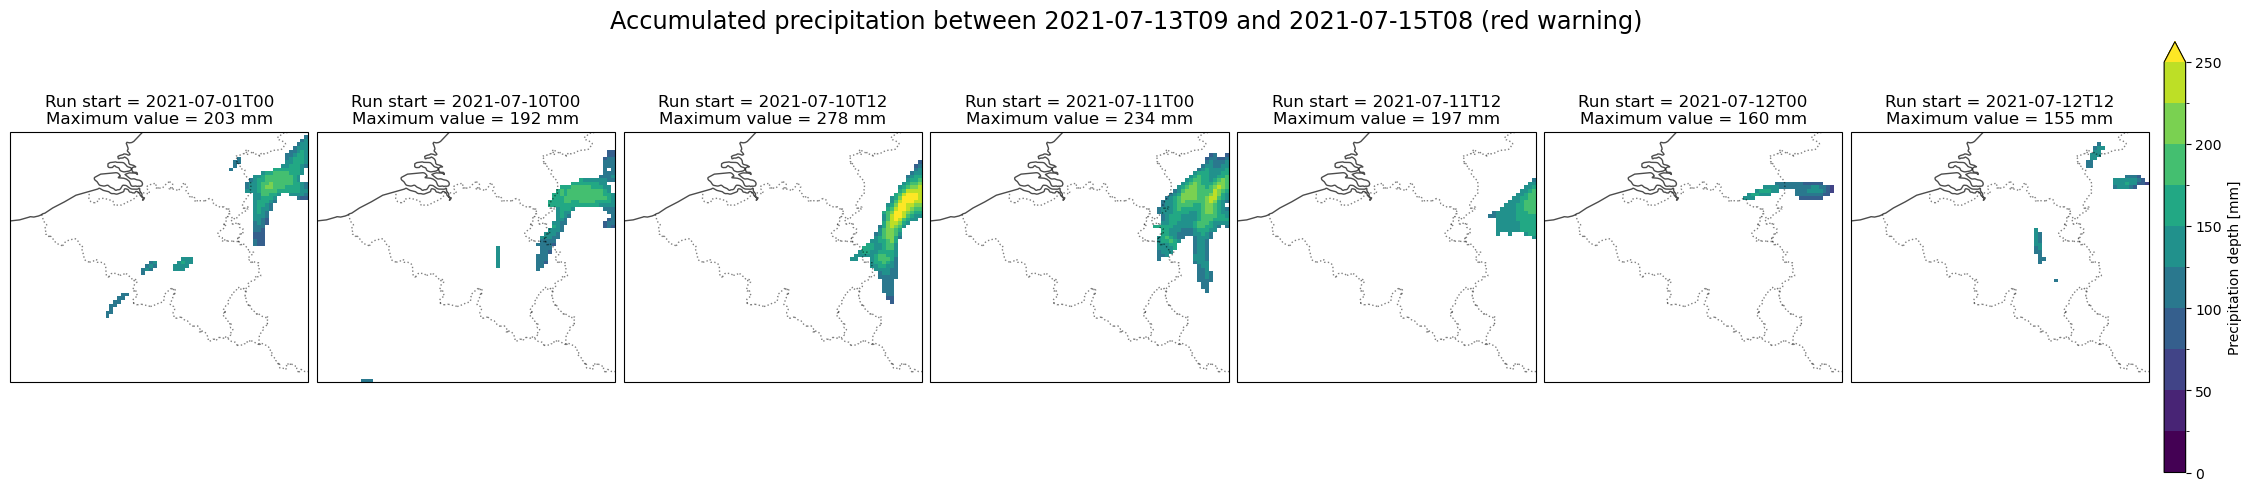

In [23]:
pr_masked_sum = pr_masked.sum("time", skipna=False)

ncols = len(run_info_list)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols * 3.2, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

for idx in range(len(run_info_list)):
    rstart, _ = run_info_list[idx]
    ax = axs[idx]
    p = pr_masked_sum.sel(rstart=rstart).plot(ax=ax, x="lon", y="lat", levels=np.arange(0, 251, 25), add_colorbar=False, extend="max")
    ax.set_title(f"Run start = {rstart[:4]}-{rstart[4:6]}-{rstart[6:8]}T{rstart[8:]}\nMaximum value = {pr_masked_sum.sel(rstart=rstart).max().values:.0f} mm")
    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
    ax.set_aspect(1.4)

fig.colorbar(p, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop} (red warning)", fontsize="xx-large")

# Open CLIMATE_GRID data

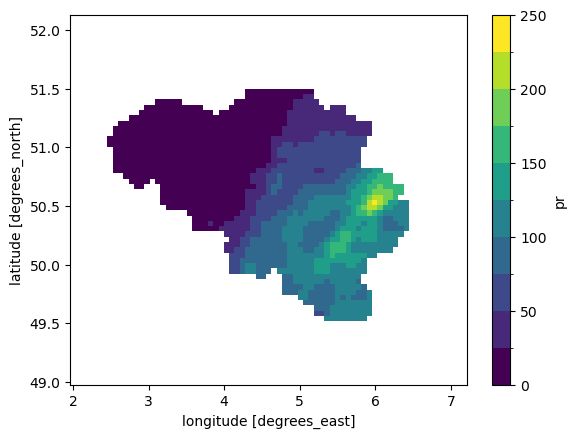

In [11]:
filepath = "../data/CLIMATE_GRID_pr_1951_2023_daily_latlon_5km.nc"
obs = xr.open_dataset(filepath, engine="netcdf4", chunks="auto")
obs = preprocess_dataset(obs, tstart="2021-07-13", tstop="2021-07-14") * 24 # !!!

obs_pr = obs.pr
obs_pr_sum = obs_pr.sum("time", skipna=False)
obs_pr_sum.plot(levels=np.arange(0, 251, 25))

Text(0.5, 0.98, 'Accumulated precipitation between 2021-07-13T09 and 2021-07-15T08')

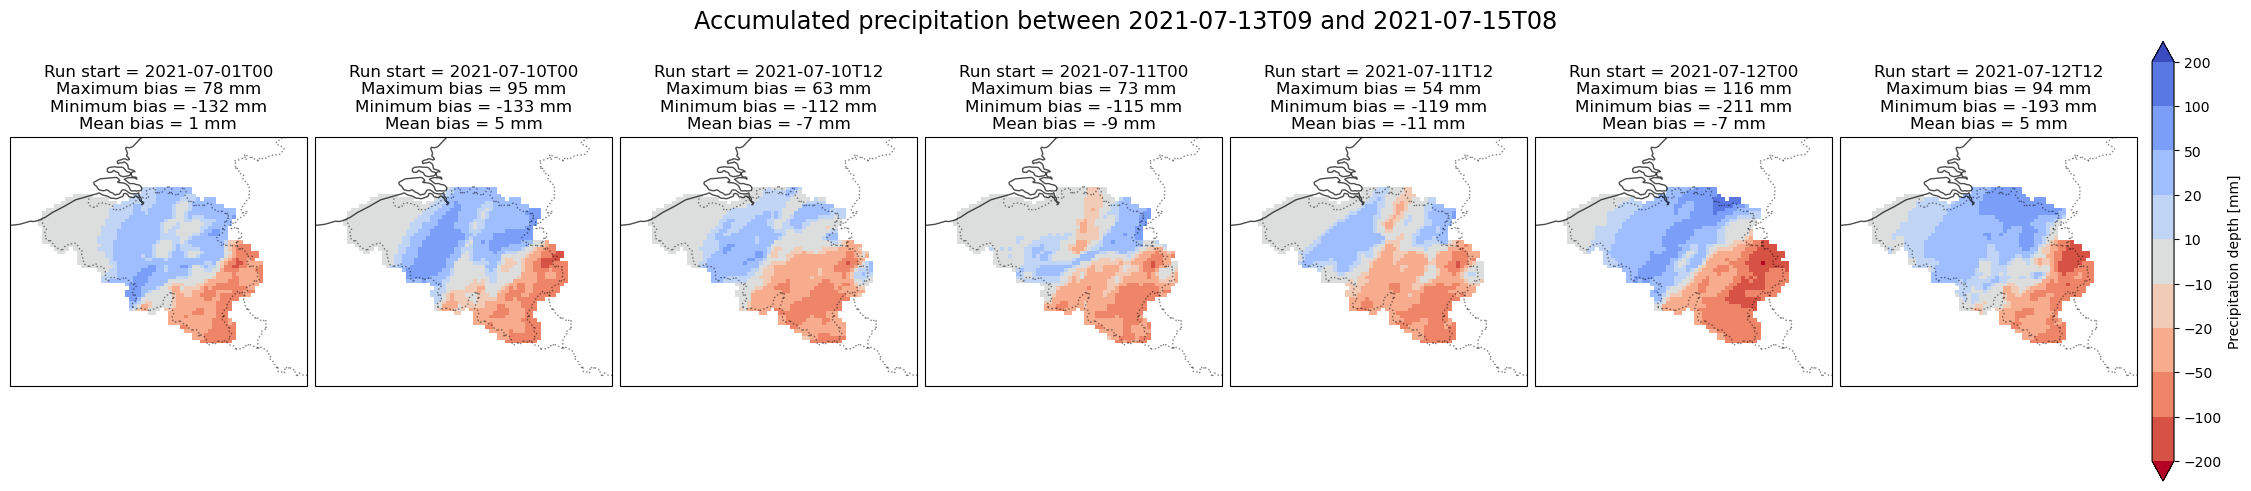

In [12]:
ncols = len(run_info_list)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols * 3.2, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

pr_sum = ds.pr.sum("time", skipna=False)
obs_pr_sum = obs.pr.sum("time", skipna=False)
bias_pr_sum = (pr_sum - obs_pr_sum)

for idx in range(len(run_info_list)):
    rstart, _ = run_info_list[idx]
    ax = axs[idx]
    p = bias_pr_sum.sel(rstart=rstart).plot(ax=ax, x="lon", y="lat", levels=[-200, -100, -50, -20, -10, 10, 20, 50, 100, 200], cmap="coolwarm_r", add_colorbar=False, extend="both")
    ax.set_title(f"Run start = {rstart[:4]}-{rstart[4:6]}-{rstart[6:8]}T{rstart[8:]}\nMaximum bias = {bias_pr_sum.sel(rstart=rstart).max().values:.0f} mm\nMinimum bias = {bias_pr_sum.sel(rstart=rstart).min().values:.0f} mm\nMean bias = {bias_pr_sum.sel(rstart=rstart).mean().values:.0f} mm")
    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
    ax.set_aspect(1.4)

fig.colorbar(p, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="xx-large")


Taking the average bias has an inherent issue? What is this and how can this be helped?

# Select data in a point

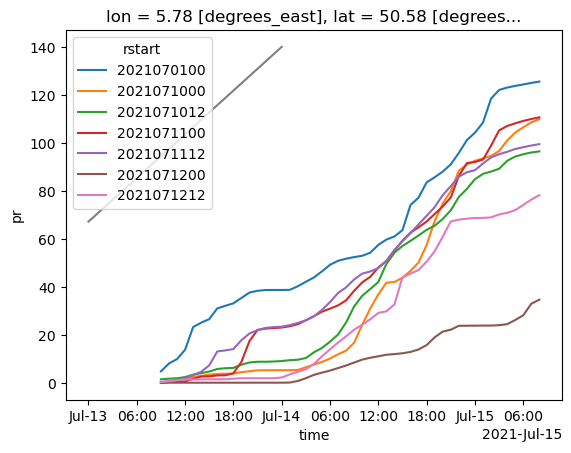

In [25]:
lat, lon = 50.7941, 4.3572 # RMI
lat, lon = 50.57506002330523, 5.800553217487655 # Pepinster
pr_point = ds.pr.sel(lat=lat, lon=lon, method="nearest")
pr_point.cumsum(dim="time").plot(x="time", hue="rstart")
obs_pr_point = obs.pr.sel(lat=lat, lon=lon, method="nearest")
obs_pr_point.cumsum(dim="time").plot(x="time", hue="rstart")